In [1]:
#cnet_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#30 July 2018
#
#train a cnet model on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [28]:
#adjust balance of training data so that X class is 2x more abundant that O,B
N_dots = 26700
X_boost = 2.0
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
train = df
train.tail(5)

class
B     905
O     905
X    1811
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score
3616,3146,9.025466,0.300964,9.030483,0.033334,B,0.0,0.0,1.0
3617,8139,-2.556454,-0.269744,2.570645,-3.036467,O,0.0,1.0,0.0
3618,2614,-5.495537,-4.827311,7.314633,-2.420837,B,0.0,0.0,1.0
3619,4939,3.249417,0.300181,3.263253,0.092119,O,0.0,1.0,0.0
3620,11359,-0.836406,-0.347638,0.905775,-2.747682,X,1.0,0.0,0.0


In [29]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x_train = train[x_cols].values
y_train = train[y_cols].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
x_train

x_train.shape =  (3621, 2)
y_train.shape =  (3621, 3)


array([[ 0.25232338,  2.29836041],
       [-3.58279167,  1.86284078],
       [ 2.01582623, -1.63788825],
       ..., 
       [-5.49553676, -4.8273109 ],
       [ 3.24941675,  0.30018113],
       [-0.83640632, -0.34763839]])

In [30]:
#generate rebalanced validation data
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
x_val = df[x_cols].values
y_val = df[y_cols].values
print 'x_val.shape = ', x_val.shape
print 'y_val.shape = ', y_val.shape
y_val

class
B     930
O     930
X    1860
Name: id, dtype: int64
x_val.shape =  (3720, 2)
y_val.shape =  (3720, 3)


array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

In [31]:
#build classifier
def cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation, Reshape, Conv2D, MaxPooling2D, Flatten
    model = Sequential()
    #input layer
    N = N_2d**2
    input_shape = (N_input,)
    layer = Dense(N, activation='elu', input_shape=input_shape)
    model.add(layer)
    #reshape input layer
    output_shape = (N_2d, N_2d, 1)
    layer = Reshape(output_shape)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    pool_size = kernel_size/2
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #flatten + output layer
    layer = Flatten()
    model.add(layer)
    model.add(Dense(N_output, activation=output_activation_fn))
    #set loss function
    if (output_activation_fn == 'linear'):
        loss_fn = 'mean_squared_error'
    if (output_activation_fn == 'sigmoid'):
        loss_fn = 'categorical_crossentropy'
    model.compile(loss=loss_fn, optimizer='adam')
    return model

In [32]:
#build CNET classification model 
N_input = len(x_cols)
N_2d = 100
kernel_size = 6
N_output = len(y_cols)
output_activation_fn = 'linear'
print 'N_input = ', N_input
print 'N_2d = ', N_2d
print 'kernel_size = ', kernel_size
print 'output_activation_fn = ', output_activation_fn
model = cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn)
model.summary()

N_input =  2
N_2d =  81
kernel_size =  10
output_activation_fn =  linear
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6561)              19683     
_________________________________________________________________
reshape_5 (Reshape)          (None, 81, 81, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 81, 81, 1)         101       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 1)         101       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 1)           0         
_________________________________________________________________
fla

In [33]:
#train model
N_training_epochs = 15
batch_size = 2000
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=1,
    validation_data=(x_val, y_val))

Train on 3621 samples, validate on 3720 samples
Epoch 1/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.3329 - val_loss: 0.2856
Epoch 2/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.2796 - val_loss: 0.2635
Epoch 3/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.2594 - val_loss: 0.2480
Epoch 4/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.2443 - val_loss: 0.2351
Epoch 5/15
3621/3621 [==============================] - 29s 8ms/step - loss: 0.2324 - val_loss: 0.2259
Epoch 6/15
3621/3621 [==============================] - 29s 8ms/step - loss: 0.2235 - val_loss: 0.2190
Epoch 7/15
3621/3621 [==============================] - 29s 8ms/step - loss: 0.2170 - val_loss: 0.2140
Epoch 8/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.2123 - val_loss: 0.2105
Epoch 9/15
3621/3621 [==============================] - 28s 8ms/step - loss: 0.2090 - val_loss: 0.2077
Epoch 10/15
3621/3621 [==

In [34]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.190598733643


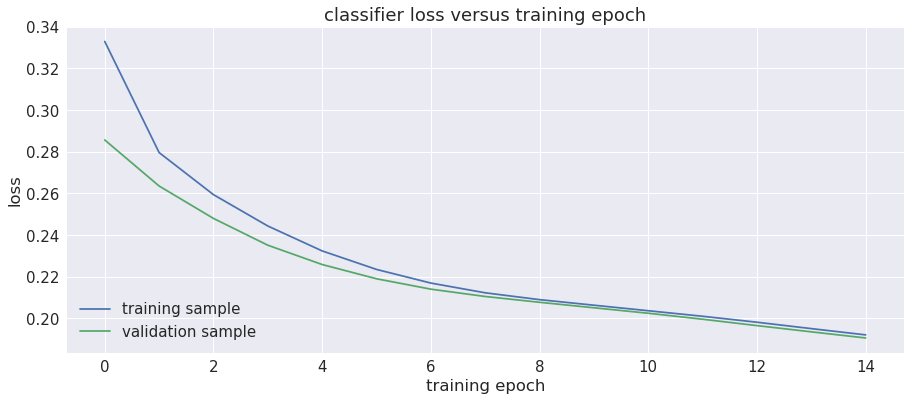

In [35]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]

In [36]:
#generate class predictions on testing X-O data
N_dots = 20000
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    df[y_col] = y_pred[:, idx]
idx = (df.O_score > df.X_score) & (df.O_score > df.B_score)
df.loc[idx, 'class_pred'] = 'O'
idx = (df.X_score > df.B_score) & (df.X_score > df.O_score)
df.loc[idx, 'class_pred'] = 'X'
idx = (df.B_score > df.O_score) & (df.B_score > df.X_score)
df.loc[idx, 'class_pred'] = 'B'
df.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,3.298836,2.307585,4.025825,0.610400,B,0.528227,0.152535,0.234947,X
1,1,-4.722200,4.553803,6.560206,2.374347,B,0.849726,0.099522,0.312803,X
2,2,-0.448700,2.290419,2.333956,1.764249,B,0.238806,0.173745,0.237065,X
3,3,2.292467,-4.085964,4.685137,-1.059502,B,0.510505,0.166116,0.303931,X
4,4,-0.388842,0.000367,0.388842,3.140648,X,0.156458,0.104299,0.077635,X


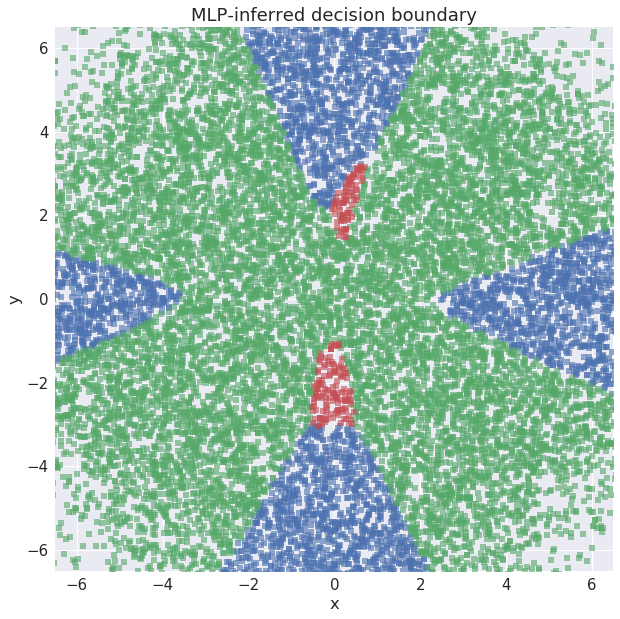

In [37]:
#scatterplot showing model's predicted decision boundaries
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_decision_boundary.png')

In [26]:
#model accuracy
idx = (df['class'] == df['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.6545


In [27]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  19.5797457298
